# 用决策树做已婚情况推断
 对于该数据集我采用的模型是决策树模型。决策树模型的优点是计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据。缺点是可能会产生过度匹配的问题。决策树模型是非常适合解决该问题的模型。
 ## 决策树模型的一般流程
收集数据：数据已经直接给出
准备数据：构造算法只适用于标称型数据，因此数值型数据必须离散化。
分析数据：可以使用任何方法，构造完树以后，我们应该检查图形是否符合预期。
训练算法：构造数的数据结构。
测试算法：使用经验树计算错误概率
 ## 处理数据
 给出数据的维度依次是CustomerID、ItemID、Sex、Age、Profession、CityType、YearsInCity、YearsInCity、Married、ItemCategory1、ItemCategory2、ItemCategory3、Amount，Married是目标数据，即要通过模型训练来判定的数据，Sex、Age、Profession、CityType、YearsInCity、YearsInCity是离散型数据，可以直接使用，ItemCategory1、ItemCategory2、ItemCategory3、Amount是数值型数据需要进行离散化处理。CustomerID、ItemID不适合使用。
 商品分类 的离散化处理可以通过判定每个订单购买最多的商品类型来进行离散化处理，输出结果为商品类型['1','2','3']。Amount的离散化处理可以先用散点图看Amount的散点图分布情况然后选定一个大概的界限。

In [1]:
import pandas as pd
import numpy as np
from mxnet import autograd, gluon, nd
data=pd.read_csv("H:\sjwj\cs.csv",encoding='utf-8')

选定训练集。先取得所有married值未缺失的数据项。以经验来看，['Sex','Age','Profession','CityType','YearsInCity']作为离散值属性看起来是对结果影响最大的，所以我首先选择的数据集包含这些维度作为训练集。

In [2]:

data_train = pd.DataFrame(data[(data['Married'] == 0) | (data['Married'] == 1)]).values
dataSet=data_train[:,2:8]
labels=['Sex','Age','Profession','CityType','YearsInCity']
print(labels)

['Sex', 'Age', 'Profession', 'CityType', 'YearsInCity']


 ## 构建决策树
使用ID3算法构建决策树
第一步先计算信息熵，信息熵计算公式：
$$H = -\sum_{i=1}^n p\left( x_i\right ) \log_2p\left( x_i\right ),$$
其中$p\left( x_i\right )$是这个类型在总数据集中出现的概率
接下来用信息熵去衡量数据集的无序程度：

In [3]:
from math import log

def calcShannonEnt(dataSet):
    numEntries = len(dataSet)  
    labelCounts = {}   
    for featVec in dataSet:
        currentLabel = featVec[-1] 
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0  
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2) 
    return shannonEnt

遍历所有特征，对于特征A：
计算特征A对数据集D的经验条件熵H(D|A)
计算特征A的信息增益g(D,A)=H(D)-H(D|A)
选择信息增益最大的特征作为当前分裂特征。先按照特征划分数据集：

In [4]:
def splitDataSet(dataSet,axis,value):
    retDataSet=[]
    for featVec in dataSet:
        if featVec[axis] == value:
            featVec=list(featVec)
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

选择出信息增益最高的划分方式：

In [5]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      
    baseEntropy = calcShannonEnt(dataSet)  
    bestInfoGain = 0.0; bestFeature = -1   
    for i in range(numFeatures):        
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)       
        newEntropy = 0.0
        for value in uniqueVals: 
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy     
        if (infoGain > bestInfoGain):      
            bestInfoGain = infoGain        
            bestFeature = i
    return bestFeature        

## 递归构建决策树
函数使用分类名称的列表，然后创创建键值为classList中唯一值得数据字典，字典对象存储了classList中每个类标签出现的频率，利用operator操作键值排序字典，返回出现次数最多的分类名称。

In [6]:
import operator
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

已经给出了从数据集构造决策树算法所需要的子功能模块，工作原理如下：
得到原始数据集，然后基于最好的属性值划分数据集，由于特征值可能多于两个，因此可能存在大于两个分支的数据集划分。第一次划分之后，数据将被乡下传递到树分支的下一个节点，在这个节点上，可以再次划分数据。
递归结束的条件是：程序遍历完所有划分数据集的属性，或者每个分支下的所有的实例都具有相同的分类。如果所有实例具有相同的分类，则得到一个叶子节点或者终止块。

In [7]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) <= 1: 
        return majorityCnt(classList) 
    bestFeat = chooseBestFeatureToSplit(dataSet)
    if bestFeat==-1:
        return classList[0]
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}} 
    del(labels[bestFeat]) 
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree
myTree=createTree(dataSet,labels)

完成训练后，用决策树执行分类

In [8]:
#使用决策树的分类函数
def classify(inputTree,featLabels,testVec):
    inputTree_keys = list(inputTree.keys())
    firstStr = inputTree_keys[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    try:
        key = testVec[featIndex]
        valueOfFeat = secondDict[key]
    except:
        return 0
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

## 模型评估
采用f1score的模型评估法
精确度：precision，正确预测为正的，占全部预测为正的比例，TP / (TP+FP)
召回率：recall，正确预测为正的，占全部实际为正的比例，TP / (TP+FN)
假设有一个大小为1000的带布尔标签数据集，里面的“真”样本只有100不到，剩下都是假样本。假设训练一个模型，不管输入什么数据，它只给出“假”的预测，那么正确率依旧是90%以上，很明显，这个时候准确率accuracy就失去它的作用。因此，查全率和查准率一般用在倾斜数据集的时候。
Precision和Recall指标有的时候是矛盾的，F-Measure综合这二者指标的评估指标，用于综合反映整体的指标。F-Measure是Precision和Recall加权调和平均, a为权重因子，当a = 1时，F值变为最常见的F1了，代表精确率和召回率的权重一样(fl_score)
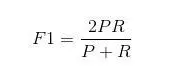
F1 值，也称为综合分类率：F1=2 * precision * recall/(precision+recall),为了综合多个类别的分类情况，评测系统整体性能，经常采用的还有微平均F1(micro-averaging)和宏平均F1(macro-averaging)两种指标。宏平均F1与微平均F1 是以两种不同的平均方式求的全局的F1指标。其中宏平均 F1 的计算方法先对每个类别单独计算F1值，再取这些F1值的算术平均值作为全局指标。而微平均F1的计算方法是先累加计算各个类别的a、b、c、d的值，再由这些值求出F1值。 由两种平均F1的计算方式不难看出，宏平均F1平等对待每一个类别，所以它的值主要受到稀有类别的影响，而微平均F1平等考虑文档集中的每一个文档，所以它的值受到常见类别的影响比较大。

In [9]:
labels=['Sex','Age','Profession','CityType','YearsInCity']
tp,fp,tn,fn=0,0,0,0
recall,precision,f1_score=0,0,0
for featVec in dataSet:
    clf=classify(myTree,labels,featVec)
    if clf==1 and featVec[-1]==1:
        tp+=1
    if clf==0 and featVec[-1]==0:
        tn+=1
    if clf==1 and featVec[-1]==0:
        fp+=1
    if clf==0 and featVec[-1]==1:
        fn+=1
precision=tp/(tp+fp)
recall=tp/(tp+fn)
f1_score=2 * precision * recall/(precision+recall)
print('recall %.4f,precision %.4f, f1 score %.4f'%(recall,precision,f1_score))

recall 0.6773,precision 0.7706, f1 score 0.7209
